In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

False


In [2]:
device = torch.device("cuda")

## Ładowanie danych

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_path = "./train"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [4]:
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
labels = dataset.classes
print(labels)

['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']


In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True, num_workers=4)

In [15]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

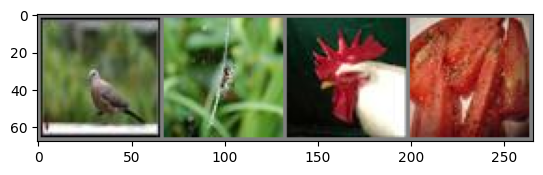

['bird', 'spider', 'bird', 'tomato']


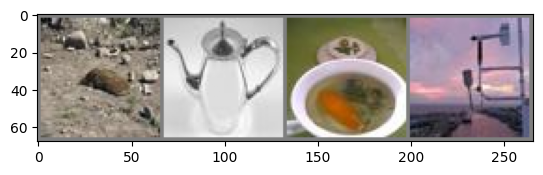

['swine', 'pot', 'tea', 'gauge']


In [7]:
train_batch, train_labels = next(iter(train_loader))
val_batch, val_labels = next(iter(val_loader))

imshow(torchvision.utils.make_grid(train_batch))
print([labels[i] for i in train_labels])
imshow(torchvision.utils.make_grid(val_batch))
print([labels[i] for i in val_labels])

## Trenowanie modelu

In [6]:
from models import Net
from helper_functions import train_model
from metric_functions import get_accuracy

In [12]:
net = Net(num_classes=len(labels)).to(device)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [09:23<00:00, 112.76s/it]


In [14]:
torch.save(net.state_dict(), "starting_model.tar")

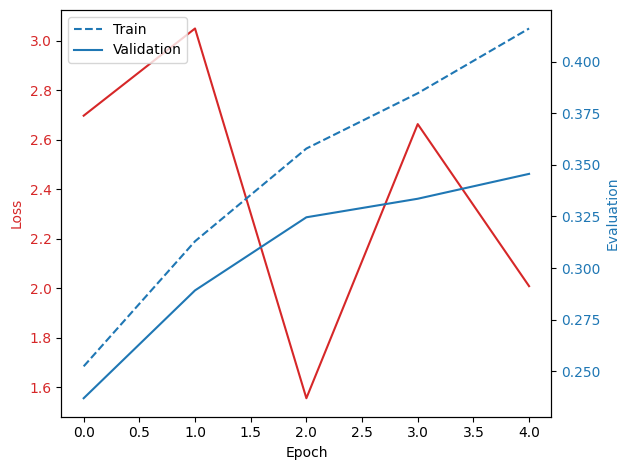

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Evaluation', color=color)
ax2.plot(train_eval_hist, color=color, linestyle='dashed', label='Train')
ax2.plot(val_eval_hist, color=color, linestyle='solid', label='Validation')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.tight_layout()
plt.show()

## Ewaluacja modelu

In [6]:
from metric_functions import get_confusion_matrix, get_balanced_accuracy

In [7]:
net = Net(num_classes=50).to(device)
net.load_state_dict(torch.load("starting_model.tar"))

AssertionError: Torch not compiled with CUDA enabled

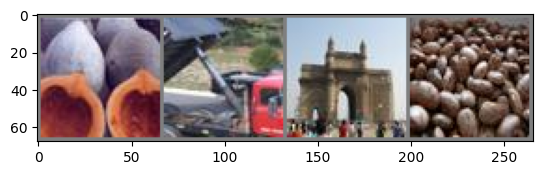

True labels:  ['squash', 'truck', 'memorial', 'bean']
Predicted labels:  ['squash', 'bacteria', 'memorial', 'spice']


In [18]:
images, img_labels = next(iter(val_loader))
images = images[:4]

output = net(images.to(device))
_, preds = torch.max(output, 1)

imshow(torchvision.utils.make_grid(images))
print("True labels: ", [labels[i] for i in img_labels[:4]])
print("Predicted labels: ", [labels[i] for i in preds])

In [16]:
final_acc = get_accuracy(net, data_loader, device)
print(f"Final accuracy: {final_acc}")

Final accuracy: 0.39384849621070095


In [9]:
balanced_accuracy_dict, balanced_accuracy = get_balanced_accuracy(net, classes=labels, data=data_loader, device=device)
print(f"Balanced accuracy: {balanced_accuracy}")

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=list(balanced_accuracy_dict.keys()), y=list(balanced_accuracy_dict.values()), ax=ax)
plt.show()

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 229, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 268, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\bruno\OneDrive - Politechnika Warszawska\homework\studia\SEM4\SSNE\LAB\projekty\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: './train\\bacteria\\n01351315_2690.JPEG'


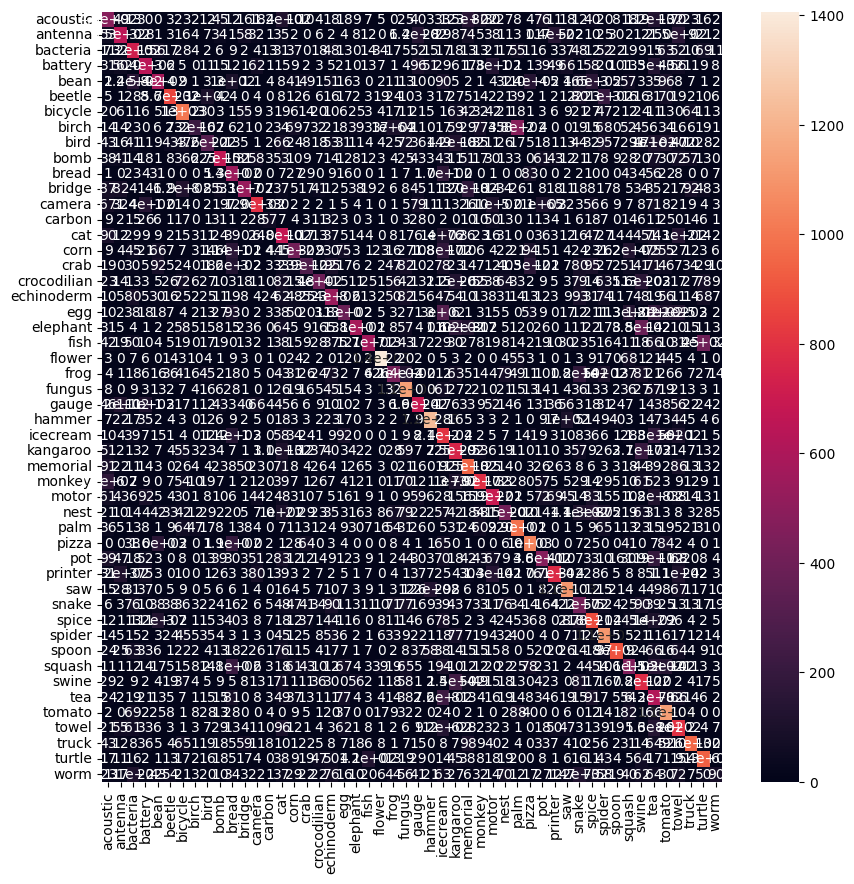

In [21]:
confusion_matrix = get_confusion_matrix(net, data_loader, classes=labels, device=device) 
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()